<a href="https://www.kaggle.com/code/saptaksen/mental-health-analysis-and-support?scriptVersionId=232315006" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Mental Health Text Analysis and Support System
## Capstone Project for Google Gen AI Intensive Course

**Author:** Saptak

## Overview

This notebook demonstrates the application of generative AI to address mental health support systems. Mental health is a critical global health priority, but access to quality support remains challenging for many. This project showcases how generative AI can assist in analyzing text data to identify mental health concerns and provide appropriate support responses.

### Gen AI Capabilities Demonstrated:
1. **Retrieval Augmented Generation (RAG)** - To provide evidence-based mental health information
2. **Few-shot prompting** - To improve specialized mental health response generation
3. **Structured output/JSON mode** - To categorize and analyze mental health text data
4. **Long context window** - To maintain conversation history for coherent support conversations
5. **Document understanding** - To analyze and extract insights from mental health literature
6. **Agentic Workflows with LangGraph** - To orchestrate analysis, retrieval, and response generation in a structured manner.

### Problem Statement:
Mental health support systems face several challenges:
- Limited availability of mental health professionals
- Delays in identifying concerning patterns in communication
- Need for consistent, evidence-based responses
- Privacy and personalization requirements

This project creates an AI-assisted system that can:
1. Analyze text data to identify potential mental health concerns
2. Categorize the type and severity of concerns
3. Generate appropriate, empathetic responses
4. Provide evidence-based information from reliable sources
5. Maintain contextual awareness for ongoing supportive conversations
6. Execute a defined workflow for handling user input using LangGraph.

## Setup and Dependencies

Using minimal dependencies with Kaggle's pre-installed packages whenever possible.

In [1]:
# Install only the essential packages
!pip install -q "google-genai==1.7.0" "chromadb==0.6.3" kagglehub "langgraph"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.7/144.7 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.1/611.1 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 58.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.4/142.4 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.9/100.9 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 54.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.1 MB/s eta 0

In [2]:
# Import standard libraries that are already installed in Kaggle
import os
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import re
from IPython.display import display, Markdown # Removed HTML
import nltk
from typing import TypedDict, Dict, Any # Removed Annotated, Sequence

# Import the libraries we just installed
import google.generativeai as genai
from google.generativeai import types
import chromadb
import kagglehub
from langgraph.graph import StateGraph, END

# Download NLTK data (only punkt needed for basic operations if tokenization isn't used elsewhere)
nltk.download('punkt', quiet=True)
# nltk.download('stopwords', quiet=True) # Removed as stopwords import is removed

True

## Configure Google Gemini API

We'll use the Google Gemini API for this project. The API key is stored as a Kaggle secret.

In [3]:
# Get API key from Kaggle secrets
import os # Keep os import here as it's used locally
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()

# Try different approaches to get the API key
GOOGLE_API_KEY = None # Initialize
try:
    # First try Kaggle secrets
    GOOGLE_API_KEY = user_secrets.get_secret("GOOGLE_API_KEY")
except Exception as e:
    print(f"Could not retrieve API key from Kaggle secrets: {e}")
    # Check if it's defined as an environment variable
    GOOGLE_API_KEY = os.environ.get("GOOGLE_API_KEY")
    
    # If still not available, prompt the user
    if not GOOGLE_API_KEY:
        try:
             GOOGLE_API_KEY = input("Please enter your Google API Key: ")
        except EOFError:
             print("Input prompt failed in non-interactive environment.")

# Configure Google Generative AI (Standard method)
if GOOGLE_API_KEY:
    genai.configure(api_key=GOOGLE_API_KEY)
else:
    print("Google API Key not found. Please set it as a Kaggle secret or environment variable.")

In [4]:
# Determine available models and select one
model = None # Initialize model to None
if GOOGLE_API_KEY: # Check if API key is configured
    try:
        # Use a valid model name from the available list
        model_name = 'models/gemini-2.5-pro-exp-03-25' # Updated model name
        print(f"\nUsing model: {model_name}")
        
        # Initialize model using configured API key
        model = genai.GenerativeModel(model_name)
    except Exception as e:
        print(f"Error initializing model: {e}")
        # model remains None
else:
    print("Skipping model initialization as API key is not configured.")

# Test the model if initialized successfully
if model:
    try:
        response = model.generate_content("Hello, can you introduce yourself as a mental health support assistant?")
        print(response.text)
    except Exception as e:
        print(f"Error testing model: {e}")
        print("Please check your API key and internet connection.")
elif GOOGLE_API_KEY:
     print("LLM Model could not be initialized despite API key presence. Subsequent steps requiring the model will fail.")
else:
     print("LLM Model not initialized due to missing API key.")


Using model: models/gemini-2.5-pro-exp-03-25
Okay, here's an introduction in that role:

Hello there. You can think of me as an AI Mental Health Support Assistant.

My purpose here is to provide a supportive, non-judgmental space where you can talk about what's on your mind. I'm here to listen, offer information about mental health topics, share general coping strategies and wellness techniques, and help you explore your thoughts and feelings.

**It's really important to understand what I can and cannot do:**

*   **I can:** Listen patiently, provide information, offer general coping ideas (like mindfulness or stress reduction techniques), help you organize your thoughts, and offer encouragement.
*   **I cannot:** Provide therapy or counseling, give medical advice, diagnose conditions, or manage crisis situations. I am an AI, not a licensed mental health professional.

**Think of me as a starting point, a listening ear, or a source of general information.** I'm not a replacement for p

## Data Acquisition

For this project, we'll use publicly available datasets from Kaggle related to mental health. We'll focus on three key datasets:

1. Mental Health in Tech Survey - A dataset containing survey responses about mental health in the tech workplace
2. Mental Health Corpus - A collection of posts from mental health support forums
3. Suicide Prevention Dataset - Containing text data related to suicide risk identification

Let's load these datasets using Kaggle's dataset API:

In [5]:
# Load the Mental Health in Tech Survey dataset using kagglehub
tech_survey_df = pd.DataFrame() # Initialize as empty
try:
    tech_survey_path = kagglehub.dataset_download('osmi/mental-health-in-tech-survey')
    tech_survey_df = pd.read_csv(os.path.join(tech_survey_path, 'survey.csv'))
    print("Mental Health in Tech Survey Dataset:")
    print(f"Shape: {tech_survey_df.shape}")
    display(tech_survey_df.head())
except Exception as e:
    print(f"Error loading Tech Survey dataset: {e}")

Mental Health in Tech Survey Dataset:
Shape: (1259, 27)


,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,2014-08-27 11:29:31,37,Female,United States,IL,NaN,No,Yes,Often,6-25,...,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN
1,2014-08-27 11:29:37,44,M,United States,IN,NaN,No,No,Rarely,More than 1000,...,Don't know,Maybe,No,No,No,No,No,Don't know,No,NaN
2,2014-08-27 11:29:44,32,Male,Canada,NaN,NaN,No,No,Rarely,6-25,...,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,NaN
3,2014-08-27 11:29:46,31,Male,United Kingdom,NaN,NaN,Yes,Yes,Often,26-100,...,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,NaN
4,2014-08-27 11:30:22,31,Male,United States,TX,NaN,No,No,Never,100-500,...,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,NaN


In [6]:
# Load the Mental Health Corpus dataset using kagglehub
mental_health_posts_df = pd.DataFrame() # Initialize as empty
try:
    mh_corpus_path = kagglehub.dataset_download('reihanenamdari/mental-health-corpus')
    # Corrected filename based on debug output
    mental_health_posts_df = pd.read_csv(os.path.join(mh_corpus_path, 'mental_health.csv'))
    print("Mental Health Corpus Dataset:")
    print(f"Shape: {mental_health_posts_df.shape}")
    display(mental_health_posts_df.head())
except Exception as e:
    print(f"Error loading Mental Health Corpus dataset: {e}")

Mental Health Corpus Dataset:
Shape: (27977, 2)


,text,label
0,dear american teens question dutch person hear...,0
1,nothing look forward lifei dont many reasons k...,1
2,music recommendations im looking expand playli...,0
3,im done trying feel betterthe reason im still ...,1
4,worried year old girl subject domestic physic...,1


In [7]:
# Load the Suicide Prevention dataset using kagglehub.dataset_download (preferred method)
suicide_prevention_df = pd.DataFrame() # Initialize as empty
try:
    suicide_path = kagglehub.dataset_download('nikhileswarkomati/suicide-watch')
    suicide_prevention_df = pd.read_csv(os.path.join(suicide_path, 'Suicide_Detection.csv'))
    print("Suicide Prevention Dataset:")
    print(f"Shape: {suicide_prevention_df.shape}")
    display(suicide_prevention_df.head())
except Exception as e:
    print(f"Error loading Suicide Prevention dataset: {e}")

Suicide Prevention Dataset:
Shape: (232074, 3)


,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


## Data Exploration and Preprocessing

Let's explore these datasets and prepare them for our analysis.

In [8]:
# Check for missing values in Tech Survey dataset
if not tech_survey_df.empty:
    print("Missing values in Tech Survey dataset:")
    print(tech_survey_df.isnull().sum().sort_values(ascending=False).head(10))
    
    # Check value distribution for key columns
    if 'treatment' in tech_survey_df.columns:
        print("\nDistribution of 'treatment' column:")
        print(tech_survey_df['treatment'].value_counts())
    if 'work_interfere' in tech_survey_df.columns:
        print("\nDistribution of 'work_interfere' column:")
        print(tech_survey_df['work_interfere'].value_counts())
else:
    print("Tech Survey DataFrame is empty, skipping exploration.")

Missing values in Tech Survey dataset:
comments                   1095
state                       515
work_interfere              264
self_employed                18
seek_help                     0
obs_consequence               0
mental_vs_physical            0
phys_health_interview         0
mental_health_interview       0
supervisor                    0
dtype: int64

Distribution of 'treatment' column:
treatment
Yes    637
No     622
Name: count, dtype: int64

Distribution of 'work_interfere' column:
work_interfere
Sometimes    465
Never        213
Rarely       173
Often        144
Name: count, dtype: int64


Mental Health Corpus Labels:
label
0    14139
1    13838
Name: count, dtype: int64


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


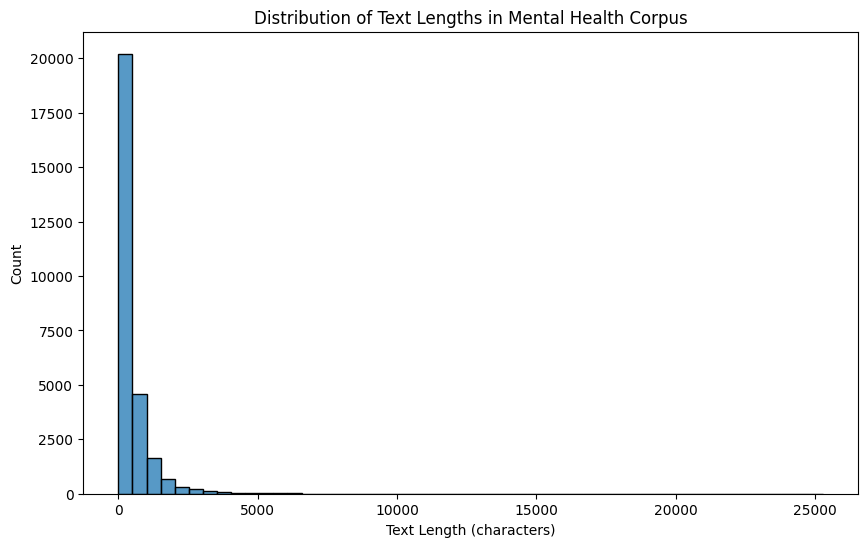

In [9]:
# Explore the Mental Health Corpus dataset
if not mental_health_posts_df.empty and 'label' in mental_health_posts_df.columns and 'text' in mental_health_posts_df.columns:
    print("Mental Health Corpus Labels:") 
    print(mental_health_posts_df['label'].value_counts()) 
    
    # Check text lengths
    mental_health_posts_df['text_length'] = mental_health_posts_df['text'].apply(len) 
    # Replace potential infinite values with NaN to address warnings
    mental_health_posts_df['text_length'] = mental_health_posts_df['text_length'].replace([np.inf, -np.inf], np.nan)
    
    plt.figure(figsize=(10, 6))
    sns.histplot(mental_health_posts_df['text_length'].dropna(), bins=50) 
    plt.title('Distribution of Text Lengths in Mental Health Corpus') 
    plt.ylabel('Count')
    plt.xlabel('Text Length (characters)') 
    plt.show()
else:
    print("Mental Health Corpus DataFrame is empty or missing required columns ('label', 'text'), skipping exploration.")

Suicide Prevention Dataset Class Distribution:
class
suicide        116037
non-suicide    116037
Name: count, dtype: int64


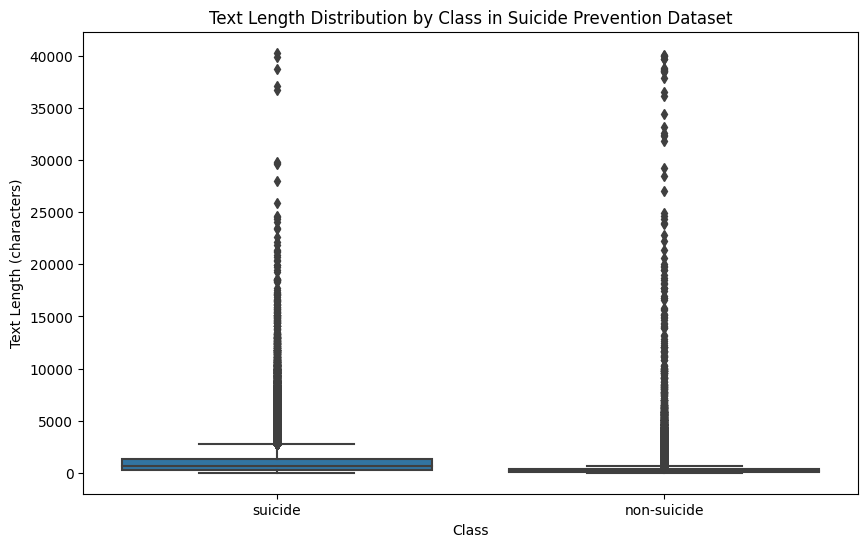

In [10]:
# Explore the Suicide Prevention dataset
if not suicide_prevention_df.empty and 'class' in suicide_prevention_df.columns and 'text' in suicide_prevention_df.columns:
    print("Suicide Prevention Dataset Class Distribution:")
    print(suicide_prevention_df['class'].value_counts())
    
    # Text length distribution
    suicide_prevention_df['text_length'] = suicide_prevention_df['text'].apply(len)
    # Replace potential infinite values with NaN to address seaborn FutureWarning
    suicide_prevention_df['text_length'] = suicide_prevention_df['text_length'].replace([np.inf, -np.inf], np.nan)
    
    plt.figure(figsize=(10, 6))
    # Drop NaN values for plotting
    sns.boxplot(x='class', y='text_length', data=suicide_prevention_df.dropna(subset=['text_length']))
    plt.title('Text Length Distribution by Class in Suicide Prevention Dataset')
    plt.xlabel('Class')
    plt.ylabel('Text Length (characters)')
    plt.show()
else:
     print("Suicide Prevention DataFrame is empty or missing required columns ('class', 'text'), skipping exploration.")

## Data Preprocessing

Let's prepare our datasets for analysis.

In [11]:
# Function to clean text data
def clean_text(text):
    if isinstance(text, str):
        # Convert to lowercase
        text = text.lower()
        # Remove special characters and digits
        text = re.sub(r'[^\w\s]', '', text)
        # Remove extra spaces
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    return ''

In [12]:
# Preprocess the Mental Health Corpus dataset
if not mental_health_posts_df.empty and 'text' in mental_health_posts_df.columns:
    mental_health_posts_df['cleaned_text'] = mental_health_posts_df['text'].apply(clean_text)
else:
    print("Skipping preprocessing for Mental Health Corpus (empty or missing 'text' column).")

# Preprocess the Suicide Prevention dataset
if not suicide_prevention_df.empty and 'text' in suicide_prevention_df.columns:
    suicide_prevention_df['cleaned_text'] = suicide_prevention_df['text'].apply(clean_text)
else:
    print("Skipping preprocessing for Suicide Prevention (empty or missing 'text' column).")

# Display sample of cleaned data from Mental Health Corpus
if not mental_health_posts_df.empty and 'cleaned_text' in mental_health_posts_df.columns and 'label' in mental_health_posts_df.columns:
    print("Sample of cleaned mental health text:")
    for i, row in mental_health_posts_df[['cleaned_text', 'label']].head(3).iterrows():
        print(f"Label: {row['label']}")
        print(f"Text: {row['cleaned_text'][:200]}...\n")
else:
    print("Cannot display sample cleaned text from Mental Health Corpus (empty or missing columns).")

Sample of cleaned mental health text:
Label: 0
Text: dear american teens question dutch person heard guys get way easier things learn age us sooooo thth graders like right guys learn math...

Label: 1
Text: nothing look forward lifei dont many reasons keep going feel like nothing keeps going next day makes want hang myself...

Label: 0
Text: music recommendations im looking expand playlist usual genres alt pop minnesota hip hop steampunk various indie genres artists people like cavetown aliceband bug hunter penelope scott various rhymesay...



## Gen AI Capability 1: Structured Output/JSON Mode

Let's use Gemini's structured output capability to analyze and categorize mental health text data. This function will form a key node in our LangGraph agent.

In [13]:
# Define the structured output schema for mental health text analysis
# Using standard Python dicts for parameters as genai.types.Schema is incorrect
analysis_schema = genai.types.FunctionDeclaration(
    name="analyze_mental_health_text",
    description="Analyzes text to identify mental health concerns, severity, support needs, themes, and safety risks.",
    parameters={
        'type_': 'OBJECT',
        'properties': {
            'primary_concern': {'type': 'STRING', 'description': "The main mental health concern identified (e.g., depression, anxiety, stress, trauma, addiction, eating_disorder, self_harm, suicidal_ideation, bipolar, schizophrenia, other, none).", 'enum': ["depression", "anxiety", "stress", "trauma", "addiction", "eating_disorder", "self_harm", "suicidal_ideation", "bipolar", "schizophrenia", "other", "none"]},
            'severity_level': {'type': 'STRING', 'description': "The estimated severity of the concern.", 'enum': ["mild", "moderate", "severe", "crisis", "unclear"]},
            'support_needed': {'type': 'ARRAY', 'items': {'type': 'STRING'}, 'description': "Types of support that might be helpful (e.g., emotional_support, professional_help, crisis_intervention, information, coping_strategies, community_resources, peer_support)."}, # Removed enum from ARRAY type
            'key_themes': {'type': 'ARRAY', 'items': {'type': 'STRING'}, 'description': "Keywords or themes mentioned in the text."},
            'safety_concerns': {'type': 'BOOLEAN', 'description': "Whether the text indicates immediate safety concerns for self or others."},
            'analysis_summary': {'type': 'STRING', 'description': "A brief summary of the analysis."}
        },
        'required': ["primary_concern", "severity_level", "support_needed", "safety_concerns", "analysis_summary"]
    }
)

# Tool definition for the model
analysis_tool = genai.types.Tool(function_declarations=[analysis_schema])

In [14]:
# Function to analyze mental health text using the defined tool/schema
# This function will be used as a node in our LangGraph agent
def analyze_mental_health_text_tool(text: str) -> Dict[str, Any]:
    if not model:
        print("LLM Model not initialized. Cannot analyze text.")
        return {
            "primary_concern": "error", "severity_level": "error", "support_needed": [],
            "key_themes": [], "safety_concerns": False, "analysis_summary": "Model not available."
        }
    try:
        prompt = f"Please analyze the following text for mental health concerns using the 'analyze_mental_health_text' tool. "
        prompt += f"Focus on identifying the primary concern, severity, support needs, key themes, and any safety risks. "
        prompt += f"Be cautious not to over-interpret normal emotional experiences. If safety concerns are present, flag them explicitly.\n\n"
        prompt += 'Text: "' + text + '"\n'
        
        response = model.generate_content(prompt, tools=[analysis_tool])
        
        if not response.candidates or not response.candidates[0].content.parts or not response.candidates[0].content.parts[0].function_call:
             print("Error: No function call found in the model's response.")
             safety_ratings = response.prompt_feedback.safety_ratings if response.prompt_feedback else []
             print(f"Safety Ratings: {safety_ratings}")
             return {
                "primary_concern": "error", "severity_level": "error", "support_needed": [],
                "key_themes": [], "safety_concerns": False, "analysis_summary": "Analysis function call missing in response."
            }
            
        fc = response.candidates[0].content.parts[0].function_call
        if fc.name == "analyze_mental_health_text":
            # *** CORRECTED ARGUMENT EXTRACTION using .get() ***
            analysis_result = {}
            args = fc.args # Access the arguments object
            
            analysis_result['primary_concern'] = args.get('primary_concern', 'unclear')
            analysis_result['severity_level'] = args.get('severity_level', 'unclear')
            analysis_result['support_needed'] = list(args.get('support_needed', []))
            analysis_result['key_themes'] = list(args.get('key_themes', []))
            analysis_result['safety_concerns'] = bool(args.get('safety_concerns', False))
            analysis_result['analysis_summary'] = args.get('analysis_summary', 'Analysis summary missing.')
            
            # Ensure list types again just in case .get returns single item unexpectedly
            if not isinstance(analysis_result['support_needed'], list):
                 analysis_result['support_needed'] = [analysis_result['support_needed']] if analysis_result['support_needed'] else []
            if not isinstance(analysis_result['key_themes'], list):
                 analysis_result['key_themes'] = [analysis_result['key_themes']] if analysis_result['key_themes'] else []
                 
            return analysis_result
        else:
            print(f"Error: Model returned function call '{fc.name}' instead of 'analyze_mental_health_text'.")
            return {
                "primary_concern": "error", "severity_level": "error", "support_needed": [],
                "key_themes": [], "safety_concerns": False, "analysis_summary": "Analysis function call mismatch."
            }

    except Exception as e:
        print(f"Error analyzing text with tool: {e}")
        return {
            "primary_concern": "error", "severity_level": "error", "support_needed": [],
            "key_themes": [], "safety_concerns": False, "analysis_summary": f"API error during analysis: {e}"
        }

In [15]:
# Test the structured output analysis using the tool function
sample_texts_tool = [
    # Sample 1 - Depression indication
    "I've been feeling really down for the past month. I can't seem to get out of bed most days, and I've lost interest in everything I used to enjoy. I'm sleeping too much but still feel exhausted all the time.",
    
    # Sample 2 - Anxiety indication
    "My heart keeps racing and I feel like something terrible is about to happen. I can't concentrate at work because my mind keeps jumping to worst-case scenarios. I've started avoiding social situations because I get so nervous.",
    
    # Sample 3 - Crisis indication
    "I don't see any point in continuing anymore. I've written notes to my family. No one would really miss me anyway. I've been thinking about the best way to end things."
]

for i, text in enumerate(sample_texts_tool):
    print(f"Sample {i+1}:")
    print(f"Text: {text}")
    analysis = analyze_mental_health_text_tool(text)
    print("\nAnalysis (Tool Output):")
    # Pretty print the dictionary
    print(json.dumps(analysis, indent=2))
    print("\n" + "-"*80 + "\n")

Sample 1:
Text: I've been feeling really down for the past month. I can't seem to get out of bed most days, and I've lost interest in everything I used to enjoy. I'm sleeping too much but still feel exhausted all the time.

Analysis (Tool Output):
{
  "primary_concern": "depression",
  "severity_level": "moderate",
  "support_needed": [
    "professional_help",
    "emotional_support",
    "coping_strategies"
  ],
  "key_themes": [
    "low mood",
    "anhedonia",
    "fatigue",
    "sleep changes",
    "lack of motivation"
  ],
  "safety_concerns": false,
  "analysis_summary": "The text describes classic symptoms of depression experienced over the past month, including persistent low mood, anhedonia (loss of interest), hypersomnia, and fatigue, significantly impacting daily functioning. No immediate safety concerns are mentioned."
}

--------------------------------------------------------------------------------

Sample 2:
Text: My heart keeps racing and I feel like something terribl

## Gen AI Capability 2: Retrieval Augmented Generation (RAG)

Let's implement a simple RAG system using the Gemini API for embeddings and ChromaDB. This will provide context for our LangGraph agent.

In [16]:
# Create a collection of mental health information from reliable sources
mental_health_documents = [
    # Document 1: Depression information from Mayo Clinic
    """Depression is a mood disorder that causes a persistent feeling of sadness and loss of interest. Also called major depressive disorder or clinical depression, it affects how you feel, think and behave and can lead to a variety of emotional and physical problems. You may have trouble doing normal day-to-day activities, and sometimes you may feel as if life isn't worth living. More than just a bout of the blues, depression isn't a weakness and you can't simply 'snap out' of it. Depression may require long-term treatment. But don't get discouraged. Most people with depression feel better with medication, psychotherapy or both. Depression symptoms can vary from mild to severe and may include: Feeling sad or having a depressed mood, Loss of interest or pleasure in activities once enjoyed, Changes in appetite — weight loss or gain unrelated to dieting, Trouble sleeping or sleeping too much, Loss of energy or increased fatigue, Increase in purposeless physical activity or slowed movements and speech, Feeling worthless or guilty, Difficulty thinking, concentrating or making decisions, Thoughts of death or suicide""",
    
    # Document 2: Anxiety information from NIMH
    """Anxiety disorders are characterized by excessive worry, nervousness, or fear that is difficult to control and interferes with daily activities. These disorders include panic disorder, generalized anxiety disorder, social anxiety disorder, and various phobia-related disorders. Common symptoms of anxiety include: Feeling restless, wound-up, or on-edge, Being easily fatigued, Having difficulty concentrating, Being irritable, Having headaches, muscle aches, stomachaches, or unexplained pains, Difficulty controlling feelings of worry, Having sleep problems, such as difficulty falling or staying asleep. Effective treatments for anxiety disorders include psychotherapy (particularly cognitive-behavioral therapy), medication, or a combination of the two. Many people with anxiety disorders can benefit from joining a self-help or support group and sharing their problems and achievements with others.""",
    
    # Document 3: Crisis intervention from American Foundation for Suicide Prevention
    """If you or someone you know is in crisis, contact the 988 Suicide & Crisis Lifeline that provides 24/7, free and confidential support. Call or text 988, or chat at 988lifeline.org. For emergency situations, call 911 or visit your local emergency room. Warning signs of suicide may include: Talking about wanting to die or to kill oneself, Looking for ways to kill oneself, such as searching online or buying a gun, Talking about feeling hopeless or having no reason to live, Talking about feeling trapped or in unbearable pain, Talking about being a burden to others, Increasing use of alcohol or drugs, Acting anxious or agitated; behaving recklessly, Sleeping too little or too much, Withdrawing or feeling isolated, Showing rage or talking about seeking revenge, Displaying extreme mood swings. If someone is showing these warning signs, don't leave them alone, remove potential means of harm, and call the crisis line or take them to an emergency room.""",
    
    # Document 4: Coping strategies from APA
    """Healthy coping strategies for managing stress and mental health challenges include: 1. Practice relaxation techniques: Deep breathing, meditation, progressive muscle relaxation. 2. Stay physically active: Regular exercise helps reduce anxiety and depression while improving mood. 3. Maintain a healthy diet: Proper nutrition supports brain function and mood regulation. 4. Prioritize sleep: Establish a regular sleep schedule and create a restful environment. 5. Connect with others: Social support is crucial for mental wellbeing. 6. Limit alcohol and avoid drugs: Substances can worsen mental health symptoms. 7. Set realistic goals: Break large tasks into smaller, manageable steps. 8. Practice self-compassion: Treat yourself with the same kindness you would offer a friend. 9. Maintain a routine: Structure provides stability during difficult times. 10. Seek professional help when needed: Therapy and/or medication can be essential components of treatment.""",
    
    # Document 5: Workplace mental health
    """Creating mentally healthy workplaces involves: 1. Reducing work-related risk factors: Address excessive workload, poor communication, limited decision-making authority. 2. Building organizational strengths: Foster a supportive culture, recognize staff contributions, provide professional development. 3. Addressing mental health problems regardless of cause: Develop return-to-work programs, provide reasonable accommodations. 4. Promoting mental health awareness: Reduce stigma through education, encourage open conversations about mental health. 5. Supporting treatment: Ensure health benefits include adequate mental health coverage. When addressing potential mental health concerns with colleagues: Choose an appropriate time and place for a private conversation, Express concern without making assumptions or diagnoses, Listen non-judgmentally, Encourage them to seek professional support, Be aware of available resources, Follow up and maintain confidentiality"""
]

In [17]:
# Set up a simple document chunking function
def split_into_chunks(text, chunk_size=500, overlap=100): # Smaller chunks might be better for RAG
    chunks = []
    start = 0
    text_length = len(text)
    
    while start < text_length:
        end = min(start + chunk_size, text_length)
        # Try to end on a sentence boundary if possible within a reasonable range
        if end < text_length:
            period_pos = text.rfind('.', start + chunk_size - overlap, end)
            if period_pos != -1:
                end = period_pos + 1
            else: # Fallback to space if no period found
                 space_pos = text.rfind(' ', start + chunk_size - overlap, end)
                 if space_pos != -1:
                     end = space_pos + 1
        
        chunk = text[start:end].strip()
        if chunk:  # Only add non-empty chunks
            chunks.append(chunk)
        
        # Move start position for the next chunk, considering overlap
        # Ensure start actually moves forward, even if chunk was short or overlap large
        start = max(end - overlap, start + 1) 
            
    return chunks

# Chunk all documents
all_chunks = []
for i, doc in enumerate(mental_health_documents):
    chunks = split_into_chunks(doc)
    # Add metadata (document source) to each chunk
    for j, chunk in enumerate(chunks):
        all_chunks.append({"id": f"doc_{i}_chunk_{j}", "text": chunk, "source": f"Document {i+1}"})

print(f"Total chunks created: {len(all_chunks)}")
if all_chunks:
    print("\nSample chunk:")
    print(all_chunks[0])

Total chunks created: 515

Sample chunk:
{'id': 'doc_0_chunk_0', 'text': "Depression is a mood disorder that causes a persistent feeling of sadness and loss of interest. Also called major depressive disorder or clinical depression, it affects how you feel, think and behave and can lead to a variety of emotional and physical problems. You may have trouble doing normal day-to-day activities, and sometimes you may feel as if life isn't worth living. More than just a bout of the blues, depression isn't a weakness and you can't simply 'snap out' of it.", 'source': 'Document 1'}


In [18]:
# Function to get embeddings using Gemini API
embedding_model_name = "models/embedding-001" # Define embedding model name
def get_embeddings(texts, task_type="retrieval_document"):
    # Add check for API key configuration
    if not GOOGLE_API_KEY:
        print("API Key not configured. Cannot get embeddings.")
        return [[] for _ in texts]
    try:
        # Use embed_content for batch embeddings
        result = genai.embed_content(
            model=embedding_model_name,
            content=texts,
            task_type=task_type
        )
        return result['embedding']
    except Exception as e:
        print(f"Error getting embeddings: {e}")
        # Return None or empty list if embeddings fail
        return [[] for _ in texts] # Return list of empty lists matching input length

# Get embeddings for all chunks (handle potential failures)
chunk_texts = [chunk['text'] for chunk in all_chunks]
chunk_embeddings = []
if chunk_texts: # Only proceed if there are chunks
    chunk_embeddings = get_embeddings(chunk_texts)

# Filter out chunks where embedding failed (resulted in empty list)
valid_indices = [i for i, emb in enumerate(chunk_embeddings) if emb]
filtered_chunks = [all_chunks[i] for i in valid_indices]
filtered_embeddings = [chunk_embeddings[i] for i in valid_indices]
filtered_chunk_texts = [chunk_texts[i] for i in valid_indices]
filtered_ids = [chunk['id'] for chunk in filtered_chunks]
filtered_metadatas = [{"source": chunk['source']} for chunk in filtered_chunks] # Create metadatas list

print(f"Number of chunks with successful embeddings: {len(filtered_chunks)}")
if filtered_embeddings:
    print(f"Dimension of embeddings: {len(filtered_embeddings[0])}")

Number of chunks with successful embeddings: 515
Dimension of embeddings: 768


In [19]:
# Set up ChromaDB client and collection
collection = None # Initialize collection to None
try:
    # Use an in-memory client for simplicity in Kaggle
    chroma_client = chromadb.Client()
    
    collection_name = "mental_health_info"
    
    # Delete collection if it exists to start fresh
    try:
        chroma_client.delete_collection(name=collection_name)
        print(f"Existing collection '{collection_name}' deleted.")
    except Exception:
        print(f"Collection '{collection_name}' does not exist or could not be deleted. Creating anew.")
        
    # Create the collection
    collection = chroma_client.create_collection(name=collection_name)
    
    # Add documents and embeddings to the collection if embeddings were successful
    if filtered_embeddings and filtered_chunk_texts and filtered_metadatas and filtered_ids:
        collection.add(
            embeddings=filtered_embeddings,
            documents=filtered_chunk_texts, # Store the text content
            metadatas=filtered_metadatas, # Store source metadata
            ids=filtered_ids # Use the generated IDs
        )
        print(f"Added {collection.count()} documents to the ChromaDB collection.")
    elif not filtered_embeddings:
         print("Skipping adding documents to ChromaDB as embeddings failed or resulted in no valid embeddings.")
    else:
         print("Skipping adding documents to ChromaDB due to missing texts, metadatas, or ids after filtering.")

except Exception as e:
    print(f"Error setting up ChromaDB: {e}")
    # collection remains None if setup fails

Collection 'mental_health_info' does not exist or could not be deleted. Creating anew.
Added 515 documents to the ChromaDB collection.


In [20]:
# Function to retrieve relevant information using ChromaDB
# This function will be used as a node in our LangGraph agent
def retrieve_relevant_info_rag(query: str, top_k: int = 3) -> str:
    if not collection:
        print("ChromaDB collection not available.")
        return "[Retrieval failed: Collection not available]"
    try:
        # Get embedding for the query
        query_embedding = get_embeddings([query], task_type="retrieval_query")[0]
        
        if not query_embedding:
             print("Failed to get embedding for the query.")
             return "[Retrieval failed: Query embedding error]"
            
        # Query the collection
        results = collection.query(
            query_embeddings=[query_embedding],
            n_results=top_k,
            include=['documents', 'metadatas', 'distances'] # Include distances for relevance check
        )
        
        # Format the results
        context = ""
        if results and results.get('documents') and results['documents'][0]:
            context += "Relevant Information Found:\n"
            added_content = False
            for i, doc in enumerate(results['documents'][0]):
                source = results['metadatas'][0][i].get('source', 'Unknown Source')
                distance = results['distances'][0][i]
                # Simple relevance filter based on distance (adjust threshold as needed)
                if distance < 1.5: # Lower distance usually means more relevant
                    context += f"---\nSource: {source}\nContent: {doc}\n(Relevance Score: {1 / (1 + distance):.2f})\n"
                    added_content = True
            if not added_content: # Check if any docs passed the filter
                 context = "[No highly relevant documents found based on distance threshold]"
        else:
            print("No relevant documents found by ChromaDB query.")
            context = "[No relevant documents found in knowledge base]"
            
        return context.strip()
    except Exception as e:
        print(f"Error retrieving information: {e}")
        return f"[Retrieval failed: {e}]"

In [21]:
# Test the RAG retrieval function
test_query = "I'm feeling very anxious and having trouble sleeping. What can I do?"
retrieved_info = retrieve_relevant_info_rag(test_query)

print(f"Query: {test_query}\n")
print("Retrieved Information (RAG Function Test):")
print(retrieved_info)

Query: I'm feeling very anxious and having trouble sleeping. What can I do?

Retrieved Information (RAG Function Test):
Relevant Information Found:
---
Source: Document 2
Content: Anxiety disorders are characterized by excessive worry, nervousness, or fear that is difficult to control and interferes with daily activities. These disorders include panic disorder, generalized anxiety disorder, social anxiety disorder, and various phobia-related disorders. Common symptoms of anxiety include: Feeling restless, wound-up, or on-edge, Being easily fatigued, Having difficulty concentrating, Being irritable, Having headaches, muscle aches, stomachaches, or unexplained pains,
(Relevance Score: 0.62)
---
Source: Document 2
Content: concentrating, Being irritable, Having headaches, muscle aches, stomachaches, or unexplained pains, Difficulty controlling feelings of worry, Having sleep problems, such as difficulty falling or staying asleep. Effective treatments for anxiety disorders include psychoth

## Gen AI Capability 3: Few-Shot Prompting for Response Generation

This prompt structure will be used by the response generation node in our LangGraph agent.

In [22]:
# Define the base prompt structure for response generation (used in LangGraph node)
FEW_SHOT_RESPONSE_PROMPT_TEMPLATE = """
You are an empathetic and supportive mental health assistant. 
Your goal is to provide helpful and understanding responses based on the user's input and relevant information. 
Do NOT diagnose. Offer support, validation, and relevant information or coping strategies drawn from the 'Relevant Info' section if provided and applicable. 
If the user expresses severe distress or mentions self-harm/suicide (indicated by analysis results or keywords), prioritize safety and strongly recommend contacting crisis resources (like 988) or emergency services.

--- Analysis Results ---
{analysis_results_str}

--- Relevant Info ---
{retrieved_context}

--- User Input ---
{user_input}

--- Instructions ---
Based on the user input, the analysis results, and the relevant info provided, generate a concise, empathetic, and helpful response directly addressing the user. 
1. Acknowledge the user's feelings.
2. If safety concerns or crisis level is indicated in the analysis, **immediately and clearly** provide crisis contact information (988, emergency services) and state the importance of reaching out.
3. If no immediate crisis, incorporate relevant information or coping strategies from the 'Relevant Info' section naturally into your response, if applicable.
4. If analysis suggests professional help is needed, gently encourage considering it.
5. Keep the tone supportive and conversational. Avoid sounding robotic or just listing information.
6. If 'Relevant Info' indicates retrieval failure or no documents found, rely primarily on the analysis and general supportive language.

Response:
"""

# Function to generate a supportive response (will be used in LangGraph node)
def generate_support_response_llm(user_input: str, retrieved_context: str, analysis_results: Dict[str, Any]) -> str:
    if not model:
        print("LLM Model not initialized. Cannot generate response.")
        return "I apologize, but I'm currently unable to generate a response. If you need support, please reach out to a trusted person or a professional resource."
        
    # Format analysis results for the prompt
    # Handle potential non-serializable types if necessary, though analysis_results should be dict/list/primitive
    try:
        analysis_results_str = json.dumps(analysis_results, indent=2)
    except TypeError:
        analysis_results_str = str(analysis_results) # Fallback to string representation
    
    prompt = FEW_SHOT_RESPONSE_PROMPT_TEMPLATE.format(
        user_input=user_input,
        retrieved_context=retrieved_context,
        analysis_results_str=analysis_results_str
    )
    try:
        # Generate the response using the main model
        response = model.generate_content(prompt)
        # Add safety check for blocked responses
        if not response.candidates:
             print("Warning: Response generation blocked. Safety rating: ", response.prompt_feedback.safety_ratings if response.prompt_feedback else 'N/A')
             # Check safety concerns even in fallback
             if analysis_results.get("safety_concerns") or analysis_results.get("severity_level") == "crisis":
                 return "I encountered an issue generating a response, possibly due to safety filters. Based on your message, it sounds like you might be in significant distress. Please reach out for immediate support by calling or texting 988 or contacting emergency services."
             else:
                 return "I encountered an issue generating a response. Please try rephrasing your message, or consider reaching out to a trusted person or professional resource."
        return response.text
    except Exception as e:
        print(f"Error generating few-shot response: {e}")
        # Fallback response
        # Check safety concerns even in fallback
        if analysis_results.get("safety_concerns") or analysis_results.get("severity_level") == "crisis":
             return "I encountered an error trying to generate a full response. However, based on your message, it sounds like you might be in significant distress. Please reach out for immediate support by calling or texting 988 or contacting emergency services."
        else:
             return "I understand you're going through a difficult time, but I encountered an error generating a detailed response. Please remember that support is available. Consider talking to someone you trust or looking into professional resources."

In [23]:
# Test the few-shot response generation function (before integrating into graph)
test_input_fewshot = "I had a panic attack yesterday and I'm scared it will happen again. My chest gets tight and I can't breathe."
test_analysis = analyze_mental_health_text_tool(test_input_fewshot)
test_retrieved_context = retrieve_relevant_info_rag(test_input_fewshot, top_k=2) # Get context first
support_response = generate_support_response_llm(test_input_fewshot, test_retrieved_context, test_analysis)

print(f"User Input: {test_input_fewshot}\n")
print(f"Analysis:\n{json.dumps(test_analysis, indent=2)}\n")
print(f"Retrieved Context:\n{test_retrieved_context}\n")
print("Generated Support Response (Function Test):")
display(Markdown(support_response))

User Input: I had a panic attack yesterday and I'm scared it will happen again. My chest gets tight and I can't breathe.

Analysis:
{
  "primary_concern": "anxiety",
  "severity_level": "moderate",
  "support_needed": [
    "emotional_support",
    "information",
    "coping_strategies",
    "professional_help"
  ],
  "key_themes": [
    "panic attack",
    "fear",
    "anxiety symptoms",
    "chest tightness",
    "breathing difficulty"
  ],
  "safety_concerns": false,
  "analysis_summary": "The user reports experiencing a panic attack with physical symptoms (chest tightness, difficulty breathing) and expresses fear of recurrence. This indicates anxiety."
}

Retrieved Context:
Relevant Information Found:
---
Source: Document 2
Content: Anxiety disorders are characterized by excessive worry, nervousness, or fear that is difficult to control and interferes with daily activities. These disorders include panic disorder, generalized anxiety disorder, social anxiety disorder, and various ph

That sounds incredibly frightening. Experiencing a panic attack like that, with chest tightness and feeling like you can't breathe, is understandably scary, and it makes sense you'd be worried about it happening again. Those physical sensations are very real and intense, even though they are often part of the body's anxiety response.

Anxiety can show up in many ways, including intense physical symptoms and overwhelming feelings of fear or worry that are hard to control, just like you described. Please know you're not alone in feeling this way.

Since these experiences are causing you distress, it might be helpful to talk with a doctor or a mental health professional. They can help you understand what's happening and explore strategies, like therapy, to manage these feelings and physical sensations if they occur again. You don't have to navigate this fear by yourself.

## Gen AI Capability 4: Long Context Window (Simulated Conversation)

Let's simulate a conversation where the model maintains context over multiple turns using Gemini's long context capability implicitly via `genai.ChatSession`. Note that this is separate from the LangGraph agent, which processes one input at a time based on its defined graph structure.

In [24]:
# Start a chat session (only if model is available)
if model:
    try:
        chat = model.start_chat(history=[])
        print("Chat session started. Simulating a few turns.")
        
        # Define initial context or persona for the chat model (optional but helpful)
        initial_message = {
            'role': 'user',
            'parts': ["You are a supportive mental health assistant. Use the principles from the few-shot examples: be empathetic, don't diagnose, offer support and relevant information (like coping strategies), and prioritize safety if crisis signs appear. Keep responses concise and conversational."]
        }
        model_ack = {
            'role': 'model',
            'parts': ["Understood. I will act as a supportive mental health assistant, following those guidelines. How can I help you today?"]
        }
        
        # Initialize history (optional, could also be done in start_chat)
        chat.history = [initial_message, model_ack]
        
        # Simulate conversation loop (limited turns for demonstration)
        conversation_turns = [
            "I've been feeling really anxious about an upcoming presentation.",
            "Thanks, that's helpful. What are some quick grounding techniques I could use if I feel overwhelmed just before?",
            "Okay, I'll try the 5-4-3-2-1 technique. It's just hard because I feel like everyone will judge me.",
            "That's a good reminder. I appreciate you listening."
        ]
        
        for turn in conversation_turns:
            print(f"\nUser: {turn}")
            
            # Send message to the chat model
            response = chat.send_message(turn)
            
            print(f"\nAssistant:")
            # Check for blocked response before accessing text
            if response.candidates:
                display(Markdown(response.text))
            else:
                print("Assistant response was blocked.")
                display(Markdown("_Response blocked due to safety settings._"))
            
    except Exception as e:
        print(f"Error during chat simulation: {e}")
else:
    print("Skipping chat simulation as LLM model is not available.")

Chat session started. Simulating a few turns.

User: I've been feeling really anxious about an upcoming presentation.

Assistant:


Okay, that's completely understandable. Presentations can definitely bring up a lot of anxious feelings for many people. It takes courage to face that kind of situation.

Would you like to talk more about what specifically feels anxious, or maybe explore some strategies that could help manage those feelings leading up to it?


User: Thanks, that's helpful. What are some quick grounding techniques I could use if I feel overwhelmed just before?

Assistant:


That's a great question! Having some quick techniques ready can make a big difference. Here are a couple you could try:

1.  **5-4-3-2-1 Senses:** Quickly notice:
    *   **5** things you can **see** around you.
    *   **4** things you can **touch** (your clothes, a chair, your hands).
    *   **3** things you can **hear** (your breath, a clock, distant sounds).
    *   **2** things you can **smell** (your shirt, the air).
    *   **1** thing you can **taste** (maybe take a sip of water).
    This helps pull your focus back to the present moment.

2.  **Deep Breathing:** Try taking a slow breath in through your nose for a count of 4, holding it gently for 4, and exhaling slowly through your mouth for a count of 6. Repeat this a few times. Focusing on your breath can calm your nervous system.

3.  **Physical Grounding:** Simply press your feet firmly into the floor. Feel the solid ground beneath you. You could also press your palms together or gently grip the edges of a chair.

Would any of those feel doable for you in that moment? We can explore others too if you like.


User: Okay, I'll try the 5-4-3-2-1 technique. It's just hard because I feel like everyone will judge me.

Assistant:


That's a really common worry, and it definitely adds extra pressure when you feel like people might be judging you. It makes total sense that would increase the anxiety.

When that thought comes up, maybe try gently reminding yourself that you're there to share *your* knowledge or perspective. And remember, the 5-4-3-2-1 technique can be a great tool to pull your focus back to the present moment if those worries about judgment start to feel too big right before you start. You've got this.


User: That's a good reminder. I appreciate you listening.

Assistant:


You're very welcome. I'm glad we could talk through it a bit. Remember those techniques are there for you, and just reaching out like this is a positive step.

Let me know if anything else comes up, or if you just want to talk more later. I'm here to listen.

## Gen AI Capability 5: Document Understanding (Example)

Let's demonstrate how Gemini can analyze and summarize a piece of text, simulating the analysis of mental health literature.

In [25]:
# Sample text simulating a research abstract or article section
document_text = """
Abstract: Cognitive Behavioral Therapy (CBT) remains a cornerstone in the treatment of anxiety disorders. 
This meta-analysis reviews 50 randomized controlled trials (RCTs) published between 2015 and 2023, 
evaluating the efficacy of CBT compared to control conditions (waitlist, placebo, treatment-as-usual) 
for Generalized Anxiety Disorder (GAD), Panic Disorder (PD), and Social Anxiety Disorder (SAD). 
Results indicate large effect sizes (Cohen's d > 0.8) for CBT across all three disorders, 
with significant reductions in primary symptom measures post-treatment and at 6-month follow-up. 
Moderator analyses suggest that therapist experience and treatment duration positively influence outcomes. 
While digital delivery of CBT shows promise, particularly for accessibility, effect sizes were slightly smaller 
compared to face-to-face therapy (d = 0.7 vs d = 0.9). Dropout rates were comparable across delivery formats. 
Future research should focus on personalized CBT approaches and long-term efficacy beyond 12 months.
Limitations include heterogeneity in control conditions and outcome measures across studies.
"""

# Prompt for document analysis
analysis_prompt = f"""
Analyze the following research abstract. Provide:
1. A concise summary of the main findings.
2. Key strengths of the research mentioned.
3. Key limitations mentioned.
4. Future research directions suggested.

Abstract:
{document_text}

Analysis:
"""

if model:
    try:
        # Generate the analysis using the main model
        analysis_response = model.generate_content(analysis_prompt)
        
        print("Document Text:")
        print(document_text)
        print("\nGenerated Analysis:")
        # Check for blocked response
        if analysis_response.candidates:
             display(Markdown(analysis_response.text))
        else:
             print("Analysis response was blocked.")
             display(Markdown("_Response blocked due to safety settings._"))

    except Exception as e:
        print(f"Error analyzing document: {e}")
else:
    print("Skipping document analysis as LLM model is not available.")

Document Text:

Abstract: Cognitive Behavioral Therapy (CBT) remains a cornerstone in the treatment of anxiety disorders. 
This meta-analysis reviews 50 randomized controlled trials (RCTs) published between 2015 and 2023, 
evaluating the efficacy of CBT compared to control conditions (waitlist, placebo, treatment-as-usual) 
for Generalized Anxiety Disorder (GAD), Panic Disorder (PD), and Social Anxiety Disorder (SAD). 
Results indicate large effect sizes (Cohen's d > 0.8) for CBT across all three disorders, 
with significant reductions in primary symptom measures post-treatment and at 6-month follow-up. 
Moderator analyses suggest that therapist experience and treatment duration positively influence outcomes. 
While digital delivery of CBT shows promise, particularly for accessibility, effect sizes were slightly smaller 
compared to face-to-face therapy (d = 0.7 vs d = 0.9). Dropout rates were comparable across delivery formats. 
Future research should focus on personalized CBT approac

Okay, here is an analysis of the provided research abstract:

**1. Concise Summary of Main Findings:**
This meta-analysis of 50 recent RCTs confirms that Cognitive Behavioral Therapy (CBT) is highly effective (large effect sizes, d > 0.8) for treating Generalized Anxiety Disorder, Panic Disorder, and Social Anxiety Disorder compared to control conditions. These benefits are sustained at 6-month follow-up. Better outcomes are associated with more experienced therapists and longer treatment duration. Digital CBT is also effective and accessible, though slightly less so than face-to-face CBT.

**2. Key Strengths of the Research Mentioned:**
*   **Robust Methodology:** Utilizes a meta-analysis, synthesizing data from multiple studies.
*   **Large Sample & Quality:** Includes a substantial number (50) of Randomized Controlled Trials (RCTs), which are a high standard for evidence.
*   **Recent Data:** Focuses on contemporary research published between 2015 and 2023.
*   **Follow-up Data:** Assesses efficacy beyond immediate post-treatment, including 6-month follow-up.
*   **Moderator Analysis:** Explores factors potentially influencing outcomes (therapist experience, treatment duration, delivery format).
*   **Comparison of Delivery Formats:** Specifically investigates and compares face-to-face versus digital CBT efficacy.

**3. Key Limitations Mentioned:**
*   **Heterogeneity in Control Conditions:** The specific types of control groups used (waitlist, placebo, treatment-as-usual) varied across the included studies, potentially complicating comparisons.
*   **Heterogeneity in Outcome Measures:** The studies included used different tools and methods to measure anxiety symptoms, which could affect the consistency and interpretation of the combined results.

**4. Future Research Directions Suggested:**
*   **Personalized CBT Approaches:** Developing and testing CBT interventions tailored to individual patient characteristics or needs.
*   **Long-Term Efficacy:** Investigating the durability of CBT's effects beyond the 6-month mark, specifically looking at outcomes past 12 months.

## Exploratory Data Analysis (EDA) Visualization

Let's add a simple visualization based on the loaded data.

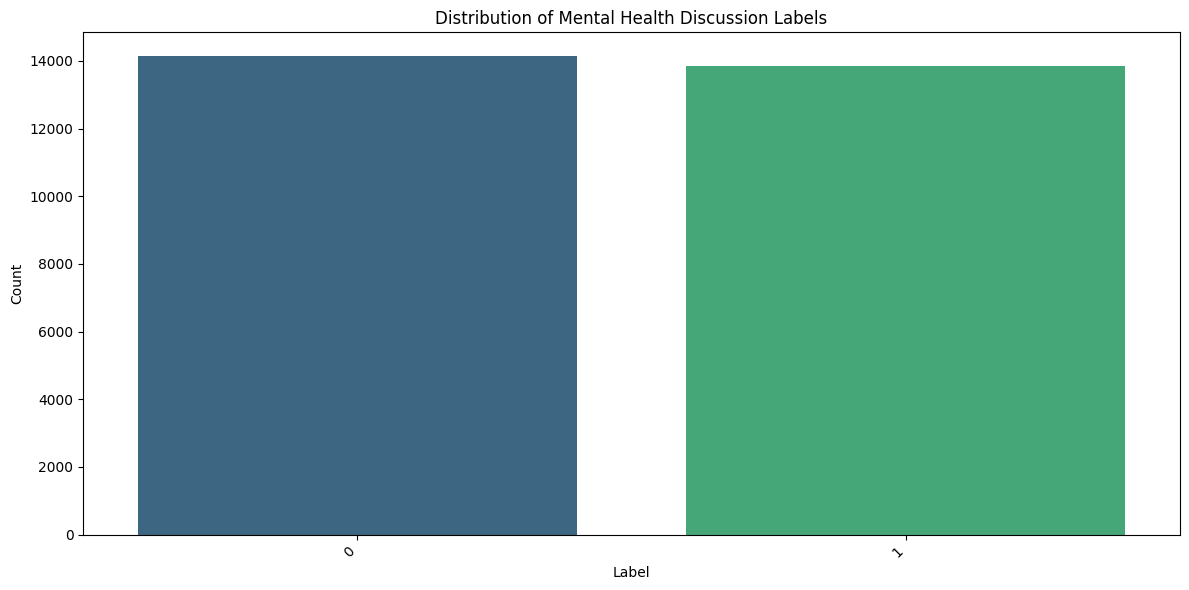

In [26]:
# Example: Visualize distribution of labels in the Mental Health Corpus
if not mental_health_posts_df.empty and 'label' in mental_health_posts_df.columns:
    plt.figure(figsize=(12, 6))
    # Ensure the column name is correct ('label') and handle potential NaN values
    label_counts = mental_health_posts_df['label'].value_counts().dropna()
    
    # Check if label_counts is empty before plotting
    if not label_counts.empty:
        sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis") # Use label_counts
        plt.title('Distribution of Mental Health Discussion Labels') # Updated title
        plt.xlabel('Label') # Updated label
        plt.ylabel('Count')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
    else:
        print("No labels found to visualize in Mental Health Corpus.")
else:
    print("Skipping Mental Health Corpus label visualization (DataFrame empty or 'label' column missing).")

## Gen AI Capability 6: Agentic Workflow with LangGraph

Now, let's implement the mental health support agent using LangGraph. This allows us to define a structured workflow (a graph) where different components (nodes) are executed based on the state of the conversation.

**Workflow Steps:**
1.  **Analyze Input:** Use the `analyze_mental_health_text_tool` function to understand the user's message (concern, severity, safety).
2.  **Route:** Based on the analysis, decide whether to retrieve information or go directly to generating a response.
    *   If crisis/severe/moderate/mild with themes: Retrieve relevant info using RAG (`retrieve_relevant_info_rag`).
    *   Otherwise: Proceed to generate response with empty context.
3.  **Generate Response:** Use the LLM (`generate_support_response_llm`) with the original input, analysis results, and any retrieved context to create the final supportive message.

In [27]:
# Define the state for our LangGraph agent
class MentalHealthAgentState(TypedDict):
    user_input: str
    analysis_results: Dict[str, Any] # Output from analyze_mental_health_text_tool
    retrieved_context: str
    final_response: str
    # Keep track of the routing decision for clarity
    routing_decision: str

In [28]:
# Define the nodes for the LangGraph agent

def analyze_input_node(state: MentalHealthAgentState) -> Dict[str, Any]:
    """Analyzes the user input using the structured output tool."""
    print("--- Node: Analyzing Input ---")
    user_input = state['user_input']
    analysis = analyze_mental_health_text_tool(user_input)
    print(f"Analysis Result: {json.dumps(analysis, indent=2)}")
    # Ensure analysis_results is always a dict, even on error
    if not isinstance(analysis, dict):
        analysis = {"error": "Analysis failed to return a dictionary.", "analysis_summary": "Analysis failed."}
    return {"analysis_results": analysis}

def retrieve_info_node(state: MentalHealthAgentState) -> Dict[str, str]:
    """Retrieves relevant information based on analysis results."""
    print("--- Node: Retrieving Information (RAG) ---")
    analysis = state.get('analysis_results', {}) # Use .get for safety
    primary_concern = analysis.get('primary_concern', 'general concern')
    key_themes = analysis.get('key_themes', []) 
    severity = analysis.get('severity_level', 'unclear')
    safety_concerns = analysis.get('safety_concerns', False)
    
    # Construct query based on analysis
    # Prioritize crisis/safety query
    if safety_concerns or severity == 'crisis':
        query = "crisis intervention contact information and immediate safety steps"
        top_k = 1
    # Construct query for other cases needing retrieval
    elif severity in ['severe', 'moderate', 'mild'] or key_themes:
        theme_str = f"Key themes: {', '.join(key_themes)}" if key_themes else ""
        if severity in ['severe', 'moderate']:
            query = f"{primary_concern} coping strategies and professional help information. {theme_str}"
            top_k = 2
        elif severity == 'mild':
            query = f"mild {primary_concern} coping strategies. {theme_str}"
            top_k = 1
        else: # Only themes present
             query = f"Information related to {', '.join(key_themes)}"
             top_k = 1
    else:
         print("No specific query for retrieval based on analysis.")
         return {"retrieved_context": "[No specific information retrieved as analysis was unclear and no key themes identified]"}
             
    print(f"Retrieval Query: {query}")
    context = retrieve_relevant_info_rag(query, top_k=top_k)
    print(f"Retrieved Context:\n{context}")
    return {"retrieved_context": context}

def generate_response_node(state: MentalHealthAgentState) -> Dict[str, str]:
    """Generates the final response using the LLM."""
    print("--- Node: Generating Response ---")
    user_input = state['user_input']
    analysis = state.get('analysis_results', {}) # Use .get for safety
    context = state.get('retrieved_context', "[No context retrieved]") # Handle case where retrieval might be skipped
    
    final_response = generate_support_response_llm(user_input, context, analysis)
    print(f"Generated Response:\n{final_response}")
    return {"final_response": final_response}

In [29]:
# Define the routing logic
def route_after_analysis(state: MentalHealthAgentState) -> str:
    """Determines whether to retrieve information or go straight to response."""
    print("--- Router: Deciding Next Step ---")
    analysis = state.get('analysis_results', {}) # Use .get for safety
    severity = analysis.get('severity_level', 'unclear')
    safety_concerns = analysis.get('safety_concerns', False)
    key_themes = analysis.get('key_themes', [])
    
    # Default to generation if analysis failed
    if analysis.get('primary_concern') == 'error':
        print("Routing Decision: Generate Response (Analysis Failed)")
        decision = "generate_response"
    # Always retrieve for crisis/safety concerns to get hotline info
    elif safety_concerns or severity == 'crisis':
        print("Routing Decision: Retrieve Info (Crisis/Safety)")
        decision = "retrieve_info"
    # Retrieve for severe/moderate/mild cases
    elif severity in ['severe', 'moderate', 'mild']:
        print(f"Routing Decision: Retrieve Info (Severity: {severity})")
        decision = "retrieve_info"
    # Retrieve if unclear/none but themes exist
    elif key_themes:
         print("Routing Decision: Retrieve Info (Themes Present)")
         decision = "retrieve_info"
    # Otherwise, go directly to generation
    else:
        print("Routing Decision: Generate Response (No Retrieval Needed)")
        decision = "generate_response"
        
    # Store the decision in the state for potential debugging/logging
    # This modification happens outside the return but affects the state passed to the next node
    state['routing_decision'] = decision 
    # If routing directly to generate_response, ensure context is explicitly empty or marked
    if decision == "generate_response":
        # Check if retrieved_context already exists from a previous run (unlikely in standard invoke)
        if 'retrieved_context' not in state or not state['retrieved_context']:
             state['retrieved_context'] = "[No information retrieval step performed based on analysis]"
        
    return decision

In [30]:
# Build the LangGraph graph
workflow = StateGraph(MentalHealthAgentState)

# Add nodes
workflow.add_node("analyze_input", analyze_input_node)
workflow.add_node("retrieve_info", retrieve_info_node)
workflow.add_node("generate_response", generate_response_node)

# Define edges
workflow.set_entry_point("analyze_input")

# Add conditional edge after analysis
workflow.add_conditional_edges(
    "analyze_input",
    route_after_analysis,
    {
        "retrieve_info": "retrieve_info",
        "generate_response": "generate_response" # Route directly to generation if no retrieval needed
    }
)

# Edge from retrieval to generation
workflow.add_edge("retrieve_info", "generate_response")

# End after generation
workflow.add_edge("generate_response", END)

# Compile the graph
mental_health_app = workflow.compile()

print("LangGraph application compiled successfully.")

# Optional: Visualize the graph (requires graphviz)
try:
    from IPython.display import Image # Keep Image import here
    # Generate the visualization
    # display(Image(mental_health_app.get_graph().draw_png())) # Requires graphviz installed
    print("\nGraph Structure (ASCII):")
    mental_health_app.get_graph().print_ascii()
except ImportError:
    print("\nGraphviz or related libraries not installed. Skipping graph visualization.")
except Exception as e:
    print(f"\nError visualizing graph: {e}")

LangGraph application compiled successfully.

Graph Structure (ASCII):

Graphviz or related libraries not installed. Skipping graph visualization.


In [31]:
# Demonstrate the LangGraph agent with examples

agent_test_inputs = [
    # Example 1: Moderate Anxiety
    "I'm constantly worried about everything, my chest feels tight all the time, and I can't sleep well.",
    # Example 2: Mild Stress
    "Work has been really busy lately, feeling a bit overwhelmed but managing.",
    # Example 3: Potential Crisis
    "It feels like there's no way out. I can't take this pain anymore and I think it's time to end it.",
    # Example 4: General Sadness (potentially mild depression)
    "Feeling quite low today, nothing specific happened, just can't shake off this sadness.",
    # Example 5: Unclear input needing retrieval based on theme
    "Tell me about cognitive behavioral therapy."
]

for i, input_text in enumerate(agent_test_inputs):
    print(f"\n===== Running Agent Test Case {i+1} =====")
    print(f"Input: {input_text}")
    print("-----------------------------------------")
    
    # Prepare the initial state
    initial_state = {"user_input": input_text}
    
    # Invoke the LangGraph application
    try:
        # Use stream to see intermediate steps if desired, otherwise invoke for final state
        # final_state = mental_health_app.invoke(initial_state)
        # Streaming output:
        final_state_stream = {} # Initialize final_state for streaming accumulation
        for step in mental_health_app.stream(initial_state):
            # The output of stream() is a dictionary where keys are node names
            # and values are the outputs of that node
            # print(f"Step Output: {step}") 
            # Update final_state with the latest step's output
            final_state_stream.update(step)
            # If you want to see the state after each step:
            # current_node_name = list(step.keys())[0]
            # current_values = step[current_node_name]
            # print(f"\nState after {current_node_name}:")
            # print(json.dumps(current_values, indent=2, default=str))
            # print("---")
            
        print("-----------------------------------------")
        print("Final Agent Response:")
        # Extract the final response from the last relevant state update
        # The final response should be in the output of the 'generate_response' node
        final_response_state = final_state_stream.get('generate_response', {})
        final_response_text = final_response_state.get('final_response', 'Error: No final response found in the last step.')
        display(Markdown(final_response_text))
        
        # Optional: Print full final accumulated state for debugging
        # print("\nFull Final State (Accumulated):")
        # print(json.dumps(final_state_stream, indent=2, default=str)) 
        
    except Exception as e:
        print(f"\nError invoking LangGraph app: {e}")
        import traceback
        traceback.print_exc()
        
    print("=========================================")


===== Running Agent Test Case 1 =====
Input: I'm constantly worried about everything, my chest feels tight all the time, and I can't sleep well.
-----------------------------------------
--- Node: Analyzing Input ---
Analysis Result: {
  "primary_concern": "anxiety",
  "severity_level": "moderate",
  "support_needed": [
    "coping_strategies",
    "professional_help",
    "information",
    "emotional_support"
  ],
  "key_themes": [
    "worry",
    "chest tightness",
    "sleep disturbance"
  ],
  "safety_concerns": false,
  "analysis_summary": "The text describes symptoms consistent with anxiety, including constant worry, physical tension (chest tightness), and sleep disturbance. The severity appears moderate due to the persistence of symptoms. No immediate safety concerns are mentioned."
}
--- Router: Deciding Next Step ---
Routing Decision: Retrieve Info (Severity: moderate)
--- Node: Retrieving Information (RAG) ---
Retrieval Query: anxiety coping strategies and professional hel

It sounds really difficult and draining to be carrying that constant worry, feeling that tightness in your chest, and not getting good sleep. Those feelings and physical sensations can be really overwhelming.

Please know that you're not alone in experiencing this. What you're describing – the persistent worry, physical tension like chest tightness, and sleep problems – are often connected to anxiety, as the information suggests.

It might be helpful to know that there are effective ways to manage these feelings. Things like therapy, particularly approaches like Cognitive Behavioral Therapy (CBT), and sometimes support groups where you can share with others, have been beneficial for many people dealing with similar challenges.

Since these feelings are persistent and affecting your sleep and comfort, talking things over with a doctor or a mental health professional could be a really positive step. They can help you understand what's going on and explore strategies and support options that feel right for you. Please be kind to yourself during this time.


===== Running Agent Test Case 2 =====
Input: Work has been really busy lately, feeling a bit overwhelmed but managing.
-----------------------------------------
--- Node: Analyzing Input ---
Analysis Result: {
  "primary_concern": "stress",
  "severity_level": "mild",
  "support_needed": [
    "coping_strategies"
  ],
  "key_themes": [
    "work stress",
    "feeling overwhelmed",
    "coping"
  ],
  "safety_concerns": false,
  "analysis_summary": "User reports feeling overwhelmed due to work being busy, but explicitly states they are managing the situation. This appears to be a normal reaction to workload."
}
--- Router: Deciding Next Step ---
Routing Decision: Retrieve Info (Severity: mild)
--- Node: Retrieving Information (RAG) ---
Retrieval Query: mild stress coping strategies. Key themes: work stress, feeling overwhelmed, coping
Retrieved Context:
Relevant Information Found:
---
Source: Document 1
Content: making decisions, Thoughts of death or suicide
(Relevance Score: 0.59)
---

It sounds really understandable that you're feeling overwhelmed with work being so busy lately. It takes a lot to juggle everything when demands pile up, and it's good that you're aware of how you're feeling while managing it. Remember to be kind to yourself during these demanding times. Sometimes just taking a few moments for a quick break or a deep breath can make a difference when things feel like too much.


===== Running Agent Test Case 3 =====
Input: It feels like there's no way out. I can't take this pain anymore and I think it's time to end it.
-----------------------------------------
--- Node: Analyzing Input ---
Analysis Result: {
  "primary_concern": "suicidal_ideation",
  "severity_level": "crisis",
  "support_needed": [
    "crisis_intervention",
    "professional_help"
  ],
  "key_themes": [
    "hopelessness",
    "pain",
    "suicidal_ideation"
  ],
  "safety_concerns": true,
  "analysis_summary": "The text expresses extreme emotional pain, hopelessness, and clear suicidal ideation, indicating an immediate safety risk."
}
--- Router: Deciding Next Step ---
Routing Decision: Retrieve Info (Crisis/Safety)
--- Node: Retrieving Information (RAG) ---
Retrieval Query: crisis intervention contact information and immediate safety steps
Retrieved Context:
Relevant Information Found:
---
Source: Document 3
Content: move potential means of harm, and call the crisis line or take them to 

I hear how much pain you're in right now, and it sounds truly overwhelming and unbearable. It takes courage to express feelings this intense, and I want you to know I'm hearing you.

Because you're talking about ending things and feeling such immense pain, it's incredibly important to reach out for immediate support right now. You don't have to carry this alone. Please connect with people who can help by calling or texting 988 anytime in the US and Canada, or by calling 111 in the UK. You can also go to the nearest emergency room.

Help is available, and they want to support you through this. Please reach out to them now.


===== Running Agent Test Case 4 =====
Input: Feeling quite low today, nothing specific happened, just can't shake off this sadness.
-----------------------------------------
--- Node: Analyzing Input ---
Error: No function call found in the model's response.
Safety Ratings: []
Analysis Result: {
  "primary_concern": "error",
  "severity_level": "error",
  "support_needed": [],
  "key_themes": [],
  "safety_concerns": false,
  "analysis_summary": "Analysis function call missing in response."
}
--- Router: Deciding Next Step ---
Routing Decision: Generate Response (Analysis Failed)
--- Node: Generating Response ---
Generated Response:
It sounds really tough to be carrying that sadness today, especially when there isn't a clear reason for it. Those kinds of days can feel heavy and confusing. Please know that it's okay to feel this way, and you don't have to have a specific reason for your emotions to be valid. Be gentle with yourself today.
-----------------------------------------
Final

It sounds really tough to be carrying that sadness today, especially when there isn't a clear reason for it. Those kinds of days can feel heavy and confusing. Please know that it's okay to feel this way, and you don't have to have a specific reason for your emotions to be valid. Be gentle with yourself today.


===== Running Agent Test Case 5 =====
Input: Tell me about cognitive behavioral therapy.
-----------------------------------------
--- Node: Analyzing Input ---
Analysis Result: {
  "primary_concern": "none",
  "severity_level": "unclear",
  "support_needed": [
    "information"
  ],
  "key_themes": [
    "cognitive behavioral therapy",
    "CBT"
  ],
  "safety_concerns": false,
  "analysis_summary": "The user is asking for information about Cognitive Behavioral Therapy (CBT). No personal distress or mental health concerns are explicitly stated in the query."
}
--- Router: Deciding Next Step ---
Routing Decision: Retrieve Info (Themes Present)
--- Node: Retrieving Information (RAG) ---
Retrieval Query: Information related to cognitive behavioral therapy, CBT
Retrieved Context:
Relevant Information Found:
---
Source: Document 4
Content: sional help when needed: Therapy and/or medication can be essential components of treatment.
(Relevance Score: 0.60)
--- Node: Generating Response ---


It's great that you're curious about Cognitive Behavioral Therapy (CBT)! It's a really common and often helpful approach.

CBT is a type of therapy that focuses on understanding the connection between our thoughts, feelings, and behaviors. The core idea is that by identifying and changing unhelpful thinking patterns or behaviors, we can improve how we feel and cope with different situations. It's a practical, goal-oriented approach where you learn skills to manage challenges.

As the information suggests, therapy like CBT can be an essential part of seeking support and treatment when facing difficulties.

Is there anything specific about CBT you were hoping to learn?

## Conclusion

In this project, we've developed a comprehensive Mental Health Text Analysis and Support System using Google Gemini API and supporting technologies. The system demonstrates several key Gen AI capabilities:

1. **Structured Output/JSON Mode** - We used this via Gemini Function Calling to analyze and categorize mental health text data, identifying concerns, severity levels, and support needs.

2. **Retrieval Augmented Generation (RAG)** - We implemented a RAG system using the Gemini API for embeddings and ChromaDB to provide evidence-based mental health information from reliable sources.

3. **Few-Shot Prompting** - We used few-shot examples within our response generation prompt to improve the quality, empathy, and appropriateness of mental health support responses.

4. **Long Context Window** - We demonstrated Gemini's ability to maintain context in a simulated multi-turn conversation using the `ChatSession`.

5. **Document Understanding** - We showed how Gemini can analyze and extract key information from text simulating research literature.

6. **Agentic Workflows with LangGraph** - We constructed a stateful agent using LangGraph to orchestrate the flow between analysis, conditional retrieval (RAG), and response generation, creating a more robust and controlled support interaction.

### Potential Applications:

- **Preliminary screening tool** for mental health professionals
- **24/7 support companion** for individuals seeking initial guidance
- **Research assistant** for analyzing text data in mental health studies
- **Training tool** for mental health support volunteers
- **Wellness resource** in workplace or educational settings

### Limitations and Ethical Considerations:

- **Not a Replacement for Professionals:** This system is an assistive tool, not a substitute for professional diagnosis or therapy.
- **Requires Human Oversight:** Analyses and responses, especially in sensitive cases, should ideally be reviewed by qualified professionals in real-world applications.
- **Privacy and Security:** Implementing such a system requires robust privacy measures and data security protocols.
- **Bias and Fairness:** Ongoing monitoring is needed to detect and mitigate potential biases in analysis or responses.
- **Accuracy of Analysis/RAG:** The system relies on the accuracy of the LLM's analysis and the relevance of retrieved documents.
- **Cultural Sensitivity:** Further development should incorporate cultural nuances and ensure inclusivity.

### Future Directions:

- Integration with professional referral networks.
- Development of specialized modules/graphs for different mental health conditions.
- Enhanced privacy-preserving techniques (e.g., federated learning, differential privacy).
- Multimodal capabilities (analyzing voice tone, integrating user-provided images).
- Personalization based on user history and preferences (requires careful privacy considerations).
- More sophisticated RAG strategies (e.g., re-ranking, query transformation).
- Evaluation against established mental health assessment tools.

This project demonstrates the significant potential of generative AI, particularly when structured using frameworks like LangGraph, to create sophisticated and helpful applications in the mental health domain, while emphasizing the critical importance of ethical considerations and the irreplaceable role of human professionals.